In [1]:
from astropy.io import fits
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def BlackBody(nu_t):
    if nu_t>15:
        spec=np.float128(nu_t**3*(np.exp(np.float128(-nu_t))))
    else:
        spec=np.float128(nu_t**3/(np.exp(np.float128(nu_t))-1))
    return spec
    
def dBlackBodydT(nu_t):
    if nu_t < 0.001:
        dbdt = nu_t**2-nu_t**4/12.0
    elif nu_t > 15:
        dbdt = nu_t**4*np.exp(-nu_t)
    else:
        dbdt=nu_t**4 *np.exp(nu_t)/(np.exp(nu_t)-1)**2   
    
    return dbdt;

In [3]:
kB=8.6173e-5 #ev
T0=2e5 #K
e0=kB*T0 #in ev which is what xstar results are in

In [29]:
#integrating the Rosseland and Planck mean opacities from TOPs

#read in the values of the temperatures and densities
f = open("gns96multi.dat", "r")
topt=[] #list of temperatures
topd=[] #list of densities
line=f.readline()
while line!='':
    if line[1]=='E':
        topd.append(float(line[-11:-1]))
        topt.append(float(line[-24:-13]))   
    line=f.readline()
f.close()


f = open("gns96multi.dat", "r")
topd=np.unique(topd)
nd=len((topd))
topt=np.unique(topt)
topt=np.array(topt)
nt=len((topt))
energy=np.zeros((nt,nd,49))
ross=np.zeros((nt,nd))
planck=np.zeros((nt,nd))
weightr=np.zeros((nt,nd))
weightp=np.zeros((nt,nd))

#read through the file until it gets
#to the multigroup opacities
line=f.readline()
while line[1]!='E':
    line=f.readline()

#integrate the multigroup opacities for each
#temperautre and density
for countt in range(nt):
    line=f.readline()
    for countd in range(nd):
        rossi=0
        plancki=0
        weightr=0
        weightp=0
        for counte in range(49):
            if line[1]=='E':
                break
            e,r,p=(line.split())
            if float(e)>0.1:
                #print(float(e)/T)
                e=float(e)#*1000/e0
                T=topt[countt]#*11604525.00617/T0
                energy[countt,countd,counte]=e/T
                rossi+=(dBlackBodydT(e/T)/float(r))
                weightr+=dBlackBodydT(e/T)
                plancki+=(float(p)*BlackBody(e/T))
                weightp+=BlackBody(e/T)
            line=f.readline()  
        ross[countt,countd]=weightr/rossi
        planck[countt,countd]=plancki/weightp
            
        line=f.readline()
        


In [6]:
#integrating the Rosseland and Planck mean opacities from XSTAR

#temperature and density grids I used in XSTAR
Tgrid=np.logspace(np.log10(5e3),np.log10(1e6),100)
rhogrid=np.logspace(-15,-7,20)/1.67e-24

#create empty arrays for the XSTAR opacities
kappa_p_fr=np.zeros((np.size(Tgrid),np.size(rhogrid)))
kappa_a_fr=np.zeros((np.size(Tgrid),np.size(rhogrid)))


for nT in range(np.size(Tgrid)):
    for nrho in range(np.size(rhogrid)):
        num=str(nT*len(rhogrid)+nrho)

        hud = fits.open('/Users/asecunda/Documents/thesis/radsims1/toyanfeiv2 (1)/work//ares/opakout'+str(num)+'.fits')
        energy=hud[3].data['energy']/e0

        T=Tgrid[nT]/T0
        rho=rhogrid[nrho]

        resulta=0
        weighta=0
        resultp=0
        weightp=0
        
        names=hud[1].data['parameter']

        for nen in range(445,960):
            de=(energy[nen-1]-energy[nen])/T
            resulta+=dBlackBodydT(energy[nen]/T)/((hud[3].data['opacity '][nen]+hud[3].data['scattering'][nen])/(1.67e-24*hud[1].data['value'][names=='density']))
            weighta+=dBlackBodydT(energy[nen]/T)

            resultp+=BlackBody(energy[nen]/T)*hud[3].data['opacity '][nen]/(1.67e-24*hud[1].data['value'][names=='density'])
            
            weightp+=(BlackBody(energy[nen]/T))

        kappa_a_fr[nT,nrho]=weighta/resulta

        kappa_p_fr[nT,nrho]=resultp/weightp

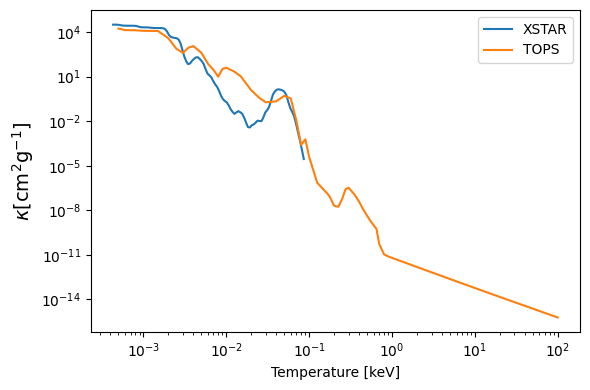

In [32]:
#plot kappa v. T for density whrho to compare TOPS and XSTAR
whrho=1e-14
fig=plt.figure(figsize=(6,4))
plt.plot(Tgrid/11604525.00617,kappa_p_fr[:,np.argmin(abs(rhogrid*1.67e-24-whrho))],label='XSTAR')
plt.plot(topt,planck[:,np.argmin(abs(topd-whrho))],label='TOPS')

#plt.xlim(5e-4,0.1)
#plt.ylim(1,10)
plt.xlabel('Temperature [keV]')
plt.ylabel(r'$\kappa [$cm$^2$g$^{-1}$]',fontsize=14)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.legend()
plt.tight_layout()

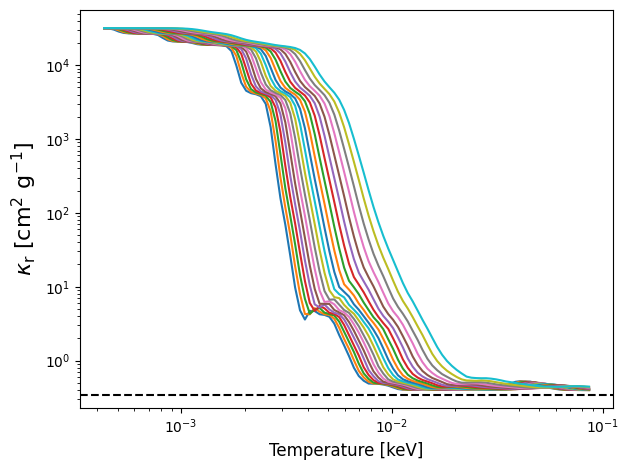

In [8]:
#plot all XSTAR rosseland means

fig=plt.figure()
plt.plot(Tgrid/11604525.00617,kappa_a_fr)
#plt.xlim(1e-4,0.1)
#plt.ylim(0.01,5)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.axhline(0.34,color='black',linestyle='dashed')
plt.xlabel('Temperature [keV]',fontsize=12)
plt.ylabel(r'$\kappa_{\rm r}$ [cm$^2~$g$^{-1}$]',fontsize=16)

plt.tight_layout()

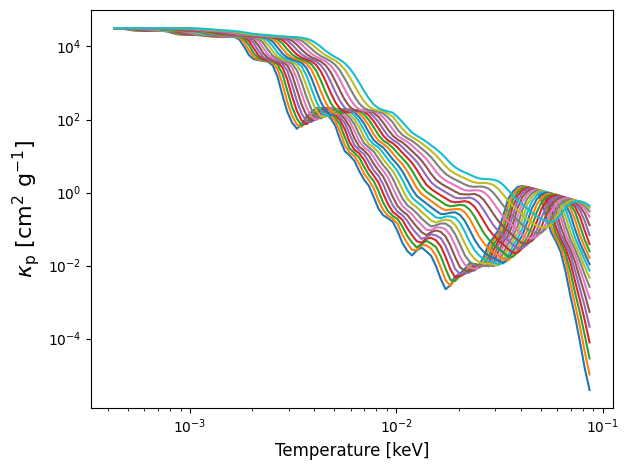

In [10]:
#plot all XSTAR Planck means

fig=plt.figure()
plt.plot(Tgrid/11604525.00617,kappa_p_fr)
#plt.xlim(1e-4,0.1)
#plt.ylim(0.001,1e6)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Temperature [keV]',fontsize=12)
plt.ylabel(r'$\kappa_{\rm p}$ [cm$^2~$g$^{-1}$]',fontsize=16)

plt.tight_layout()